In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='vinayak@60',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:/Data Analytics/Projects/Python and Sql Projects/Ecommerce Project/Ecommerce Datasets'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

In [2]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host = "localhost",
    username = "root",
    password = "vinayak@60",
    database = "ecommerce")

cur = db.cursor()



# List all unique cities where customers are located. 

In [5]:
query = """select distinct(customer_city) as city from customers """

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data,columns = ["City"])
df.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [17]:
query = """Select Count(*) from orders
            where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are = " , data[0][0]

('total orders placed in 2017 are = ', 45101)

# Find the total sales per category.

In [44]:
import pandas as pd
query = """Select upper(t1.product_category) as 'Category',
            round(sum(t3.payment_value),2) as 'Total_Sales'
            from products t1
            join order_items t2
            on t1.product_id = t2.product_id
            join payments t3
            on t2.order_id = t3.order_id
            group by product_category"""
            

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns=["Category", "Total_Sales"])
df

,Category,Total_Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [49]:
query = """ select 
            sum(case when payment_installments>=1 then 1 else 0 end)/count(*)*100
            from payments"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is ", data[0][0]

('the percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# Count the number of customers from each state.

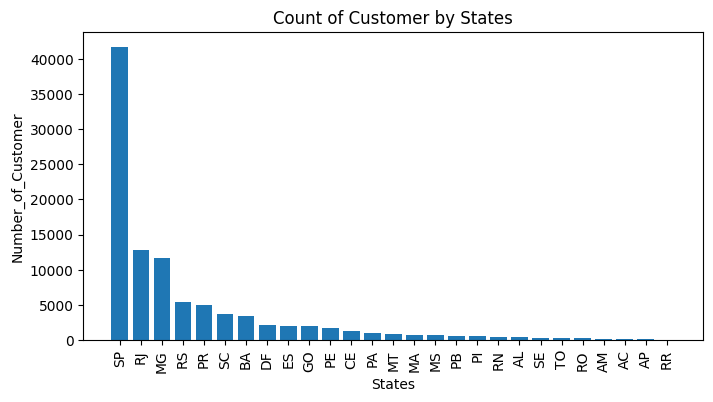

In [102]:
import pandas as pd
query = """ Select customer_state as States, Count(*) as "Number_of_Customer" from customers
            group by customer_state
            order by Number_of_Customer desc"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["States","Number_of_Customer"])
df
#df = df.sort_values(by = "Number_of_Customer", ascending = False)
plt.figure(figsize = (8,4))
plt.bar(df["States"],df["Number_of_Customer"])
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("Number_of_Customer")
plt.title("Count of Customer by States")
plt.show()

# Calculate the number of orders per month in 2018

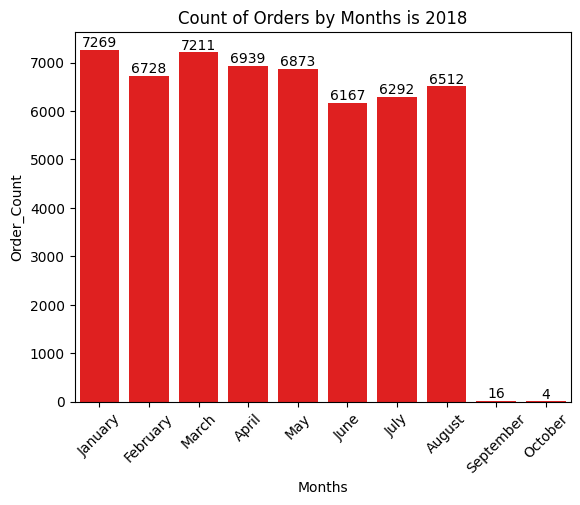

In [39]:
query = """ Select monthname(order_purchase_timestamp) as Months,
            Count(*) as "Order_Count"
            from orders
            where year(order_purchase_timestamp) = 2018
            group by Months"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Months","Order_Count"])
df
o = ["January","February","March","April","May","June","July","August","September","October"]
ax = sns.barplot(x = df["Months"], y= df["Order_Count"],data= df,order = o,color = "red")
plt.xticks(rotation = 45)
plt.title("Count of Orders by Months is 2018")
ax.bar_label(ax.containers[0])
plt.show()

# Find the average number of products per order, grouped by customer city

In [16]:
query  = """with count_per_order as
            (Select t1.customer_id,t1.order_id, 
            count(*) as order_count from orders t1
            join order_items t2
            on t1.order_id = t2.order_id
            group by t1.customer_id,t1.order_id)

            select t3.customer_city, 
            round(avg(t4.order_count),2) as Average_Order 
            from customers t3 join count_per_order t4
            on t3.customer_id = t4.customer_id
            group by customer_city
            order by Average_Order desc"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Customer_City","Average_Order"])
df.head()

,Customer_City,Average_Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00


# Calculate the percentage of total revenue contributed by each product category

In [27]:
query = """ Select t1.product_category,
            round((Sum(t3.payment_value)/
            (Select Sum(payment_value) from payments))*100,2) 
            as Total_Percentage_payment 
            from products t1 
            join order_items t2
            on t1.product_id = t2.product_id
            join payments t3
            on t2.order_id = t3.order_id
            group by product_category
            order by Total_Percentage_payment desc"""

cur.execute(query)

cur.fetchall()

data 

df = pd.DataFrame(data,columns= ["Product Category","Total_Percentage_payment"])
df.head()

 

,Product Category,Total_Percentage_payment
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00


# Identify the correlation between product price and the number of times a product has been purchased


In [40]:
import numpy as np
query =  """select t1.product_category,
            count(*),
            round(avg(t2.price),2) as Average_Value 
            from products t1
            join order_items t2
            on t1.product_id = t2.product_id
            group by product_category
            order by Average_Value desc"""


cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Product Category", "Order_Count","Average_Value"])
df.head()
arr1 = df["Order_Count"]
arr2 = df["Average_Value"]
a = np.corrcoef([arr1,arr2])
print("the correlation between product price and the number of times a product has been purchased is",a[0][1])


the correlation between product price and the number of times a product has been purchased is -0.10631514167157557


# Calculate the total revenue generated by each seller, and rank them by revenue.

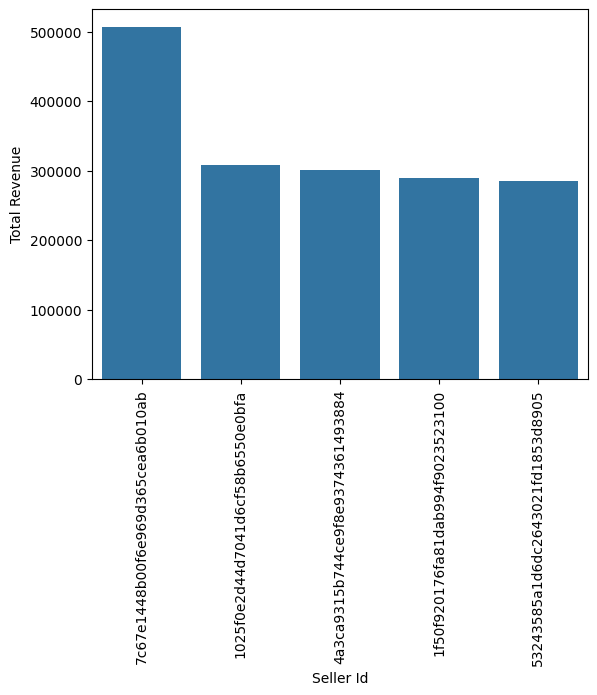

In [21]:
query =  """Select *, dense_rank() 
            over(order by Total_Revenue desc) as Seller_Rank
            from 
            (select t1.seller_id, 
            sum(t2.payment_value) as Total_Revenue
            from order_items t1
            join payments t2
            on t1.order_id = t2.order_id 
            group by t1.seller_id) as t"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Seller Id","Total Revenue","Seller Rank"])
df1 = df.head()
sns.barplot(data = df1, x="Seller Id", y= "Total Revenue")
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.


In [41]:
query = """ select customer_id, order_purchase_timestamp,
            avg(payment) over(partition by customer_id 
            order by order_purchase_timestamp
            rows between 2 preceding and current row) as mov_avg
            from
            (select t1.customer_id,
            t1.order_purchase_timestamp,
            t2.payment_value as payment from orders t1 
            join payments t2
            on t1.order_id = t2.order_id) as t"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer Id","TimeStamp","Moving Average"])
df.head()

,Customer Id,TimeStamp,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002


# Calculate the cumulative sales per month for each year.


In [26]:
query = """ select years,months,payments,round(sum(payments)
            over(order by years,months),2) as cumulative_sales from
            (select year(order_purchase_timestamp) as years,
            month(order_purchase_timestamp) as months ,
            round(sum(t2.payment_value),2) as payments
            from orders t1
            join payments t2
            on t1.order_id = t2.order_id
            group by years,months order by years,months) t"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns=["Years","Months","Payments","Cumulative Sales"])
df

,Years,Months,Payments,Cumulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.

In [27]:
query = """ with t as 
            (select year(order_purchase_timestamp) as years,
            round(sum(t2.payment_value),2) as payments 
            from orders t1
            join payments t2
            on t1.order_id = t2.order_id
            group by years
            order by years) 

            select years,((payments - lag(payments,1) 
            over(order by years))/lag(payments,1) 
            over(order by years))*100 as previous_year
            from t"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns=["Year","YOY Growth"])
df

,Year,YOY Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [28]:
query = """ With a as (select t1.customer_id,
            min(order_purchase_timestamp) as first_order
            from customers t1
            join orders t2
            on t1.customer_id = t2.customer_id
            group by t1.customer_id),

            b as (select a.customer_id,
            count(distinct t3.order_purchase_timestamp) as next_order
            from a join orders t3
            on a.customer_id = t3.customer_id
            and t3.order_purchase_timestamp > first_order
            and t3.order_purchase_timestamp < 
            date_add(first_order,interval 6 month)
            group by a.customer_id)

            select 100 * (count( distinct a.customer_id)/
            count(distinct b.customer_id))
            from a left join b 
            on a.customer_id = b.customer_id"""

cur.execute(query)

data = cur.fetchall()
data


[(None,)]

# Identify the top 3 customers who spent the most money in each year.

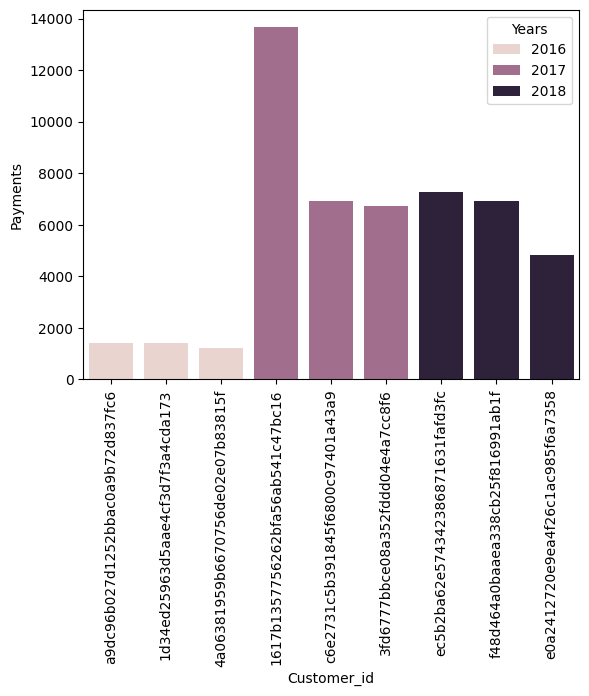

In [38]:
query = """ select customer_id,years,payments,d_rank from
            (select t1.customer_id,
            year(t1.order_purchase_timestamp) as years,
            sum(t2.payment_value) as payments,
            dense_rank() 
            over(partition by year(t1.order_purchase_timestamp) 
            order by sum(t2.payment_value) desc) as d_rank
            from orders t1
            join payments t2
            on t1.order_id = t2.order_id
            group by years,customer_id) as t
            where d_rank<4 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer_id","Years","Payments","Rank"])
sns.barplot(data =df,x = "Customer_id",y= "Payments", hue = "Years")
plt.xticks(rotation = 90)
plt.show()

